In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Chuẩn bị dữ liệu
data = pd.read_csv('../Dataset/ACB-Historical-Data_Group 9.csv', index_col='Date', parse_dates=True)

# Hàm chuyển đổi
def convert_str_to_number(str):
    return float(str.replace(',', ''))

def convert_change_to_number(change_str):
    return float(change_str.strip('%')) / 100

def convert_volume_to_number(volume_str):
    factor = {'K': 1000, 'M': 1000000, 'B': 1000000000}
    return int(float(volume_str[:-1]) * factor[volume_str[-1]]) if volume_str[-1] in factor else int(volume_str)

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'], data['Open'], data['High'], data['Low'] = [data[col].apply(convert_str_to_number) for col in ['Price', 'Open', 'High', 'Low']]
data['Change %'] = data['Change %'].apply(convert_change_to_number)
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

data.reset_index(drop=True, inplace=True)
data.head(10)

,Price,Open,High,Low,Vol.,Change %
0,11361.0,11285.2,11398.8,11171.6,3910000,0.0101
1,11512.4,11361.0,11550.3,11323.1,8240000,0.0133
2,11474.6,11512.4,11626.0,11398.8,6510000,-0.0033
3,11474.6,11436.7,11512.4,11361.0,3110000,0.0000
4,11550.3,11512.4,11626.0,11474.6,8720000,0.0066
5,11474.6,11512.4,11588.2,11436.7,3740000,-0.0066
6,11512.4,11474.6,11588.2,11436.7,2730000,0.0033
7,11701.8,11550.3,11701.8,11474.6,6610000,0.0165
8,11891.1,11777.5,12004.7,11701.8,14450000,0.0162
9,11929.0,11891.1,12118.4,11853.3,6160000,0.0032


In [2]:
price = data['Price'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Chia dữ liệu thành train test validate
train_size, test_size = int(len(price_scaled) * 0.8), int(len(price_scaled) * 0.15)
val_size = len(price_scaled) - train_size - test_size

train_data, test_data, val_data = [price_scaled[:train_size], price_scaled[train_size:train_size+test_size], price_scaled[train_size+test_size:]]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)
X_val, Y_val = create_dataset(val_data, look_back)

X_train, X_test, X_val = [X.reshape(X.shape[0], X.shape[1], 1) for X in [X_train, X_test, X_val]]


In [3]:
print(X_train)

[[[0.12029041]
  [0.12730068]
  [0.12555043]
  ...
  [0.12905556]
  [0.12379554]
  [0.12555043]]

 [[0.12730068]
  [0.12555043]
  [0.12555043]
  ...
  [0.12379554]
  [0.12555043]
  [0.12379554]]

 [[0.12555043]
  [0.12555043]
  [0.12905556]
  ...
  [0.12555043]
  [0.12379554]
  [0.12029041]]

 ...

 [[0.68004667]
  [0.71477388]
  [0.72866476]
  ...
  [0.77033741]
  [0.73329506]
  [0.71708903]]

 [[0.71477388]
  [0.72866476]
  [0.71245873]
  ...
  [0.73329506]
  [0.71708903]
  [0.72403447]]

 [[0.72866476]
  [0.71245873]
  [0.75181623]
  ...
  [0.71708903]
  [0.72403447]
  [0.75876167]]]


In [4]:
# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_val, Y_val))

Epoch 1/100
16/16 [==============================] - 1s 28ms/step - loss: 0.3146 - val_loss: 0.6883
Epoch 2/100
16/16 [==============================] - 0s 16ms/step - loss: 0.3146 - val_loss: 0.6883
Epoch 3/100
16/16 [==============================] - 0s 16ms/step - loss: 0.3146 - val_loss: 0.6883
Epoch 4/100
16/16 [==============================] - 0s 16ms/step - loss: 0.3146 - val_loss: 0.6883
Epoch 5/100
16/16 [==============================] - 0s 16ms/step - loss: 0.3146 - val_loss: 0.6883
Epoch 6/100
16/16 [==============================] - 0s 16ms/step - loss: 0.3146 - val_loss: 0.6883
Epoch 7/100
16/16 [==============================] - 0s 16ms/step - loss: 0.3146 - val_loss: 0.6883
Epoch 8/100
16/16 [==============================] - 0s 16ms/step - loss: 0.3146 - val_loss: 0.6883
Epoch 9/100
16/16 [==============================] - 0s 16ms/step - loss: 0.3146 - val_loss: 0.6883
Epoch 10/100
16/16 [==============================] - 0s 16ms/step - loss: 0.3146 - val_loss: 0.6883

In [5]:
# Dự báo
test_predict = model.predict(X_test)
val_predict = model.predict(X_val)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
val_predict = scaler.inverse_transform(val_predict)
Y_val = scaler.inverse_transform([Y_val])

2/2 [==============================] - 0s 6ms/step


In [6]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-30:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat, axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

1/1 [==============================] - 0s 23ms/step
[[8763.1   ]
 [8763.1   ]
 [8763.1   ]
 [8763.1   ]
 [8763.1   ]
 [8763.1   ]
 [8765.516 ]
 [8765.516 ]
 [8772.526 ]
 [8772.526 ]
 [8774.3955]
 [8774.3955]
 [8774.3955]
 [8774.3955]
 [8774.3955]
 [8774.3955]
 [8774.3955]
 [8774.3955]
 [8774.3955]
 [8774.3955]
 [8774.3955]
 [8774.3955]
 [8774.3955]
 [8774.3955]
 [8774.3955]
 [8774.3955]
 [8771.98  ]
 [8771.98  ]
 [8764.969 ]
 [8764.969 ]]


In [7]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index

val_predict_df = pd.DataFrame(val_predict)
val_predict_index = range(len(train_data)+len(test_data)+look_back, len(train_data)+len(test_data)+look_back+len(val_predict))
val_predict_df.index = val_predict_index

next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(data), len(data)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = data[:train_size][['Price']]
test_data_df = data[train_size:train_size + test_size][['Price']]
val_data_df = data[train_size+test_size:][['Price']]

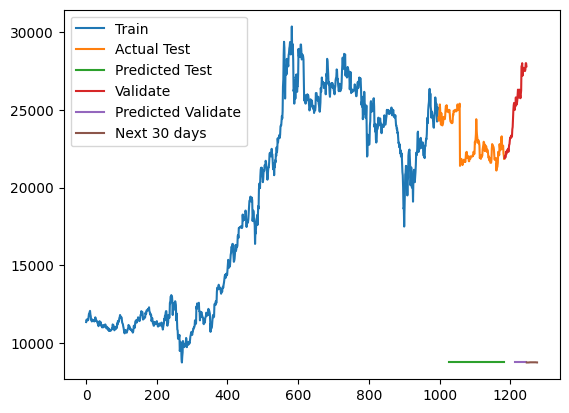

In [8]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(val_data_df, label='Validate')
plt.plot(val_predict_df, label='Predicted Validate')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.show()



Đánh giá mô hình

In [9]:
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mae = mean_absolute_error(Y_test[0], test_predict[:, 0])
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0])

print('RMSE :', test_score_rmse)
print('MAE :', test_score_mae)
print('MAPE :', test_score_mape)

RMSE : 14015.856447255881
MAE : 13969.06599572054
MAPE : 0.6135745310896342


In [10]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Giả sử Y_val, val_predict, Y_test và test_predict đã có sẵn
# Y_val[0] là các giá trị thực tế của tập val
# val_predict[:, 0] là các giá trị dự đoán của tập val
# Y_test[0] là các giá trị thực tế của tập test
# test_predict[:, 0] là các giá trị dự đoán của tập test

# Tính các chỉ số cho tập validation
val_rmse = np.sqrt(mean_squared_error(Y_val[0], val_predict[:, 0]))
val_mae = mean_absolute_error(Y_val[0], val_predict[:, 0])
val_mape = mean_absolute_percentage_error(Y_val[0], val_predict[:, 0])
val_directional_errors = np.abs(np.sign(Y_val[0][1:] - Y_val[0][:-1]) - np.sign(val_predict[1:, 0] - val_predict[:-1, 0]))
val_made = np.mean(val_directional_errors)
val_mda = np.mean(np.sign(Y_val[0][1:] - Y_val[0][:-1]) == np.sign(val_predict[1:, 0] - val_predict[:-1, 0])) * 100

print('Validation RMSE:', val_rmse)
print('Validation MAE:', val_mae)
print('Validation MAPE:', val_mape)
print('Validation MADE:', val_made)
print('Validation MDA:', val_mda)

# Tính các chỉ số cho tập test
test_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_mae = mean_absolute_error(Y_test[0], test_predict[:, 0])
test_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0])
test_directional_errors = np.abs(np.sign(Y_test[0][1:] - Y_test[0][:-1]) - np.sign(test_predict[1:, 0] - test_predict[:-1, 0]))
test_made = np.mean(test_directional_errors)
test_mda = np.mean(np.sign(Y_test[0][1:] - Y_test[0][:-1]) == np.sign(test_predict[1:, 0] - test_predict[:-1, 0])) * 100

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)
print('Testing MADE:', test_made)
print('Testing MDA:', test_mda)


Validation RMSE: 17917.624778628455
Validation MAE: 17889.930693655304
Validation MAPE: 0.6707567483767995
Validation MADE: 0.8125
Validation MDA: 18.75
Testing RMSE: 14015.856447255881
Testing MAE: 13969.06599572054
Testing MAPE: 0.6135745310896342
Testing MADE: 0.8589743589743589
Testing MDA: 14.102564102564102
